In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
%matplotlib inline  

### Variational Autoencoder

* https://arxiv.org/pdf/1312.6114.pdf
* http://norman3.github.io/prml/docs/chapter10/0.html
* http://nolsigan.com/blog/what-is-variational-autoencoder/
* http://jaejunyoo.blogspot.com/2017/04/auto-encoding-variational-bayes-vae-2.html
* https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/variational_auto_encoder

 From a neural network perspective, the only difference between the VAE and the Auto-Encoder(AE) is that the latent vector z in VAE is stochastically sampled. This solves the problem that the AE learns identity mapping and can not have meaningful representations in latent space. In fact, the VAE uses reparameterization trick to enable back propagation without sampling z directly from the mean and variance.

In [2]:
# Hyper Parameters 
input_size = 784
hidden_size = 400 # undercomplete !
num_epochs = 50
batch_size = 100
learning_rate = 0.001

In [3]:
# MNIST Dataset (Images and Labels)
train_dataset = dsets.MNIST(root='../../dataset/mnist', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='../../dataset/mnist', 
                           train=False, 
                           transform=transforms.ToTensor())

# Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [4]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [5]:
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, z_dim*2))  # 2 for mean and variance.
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid())
    
    def reparametrize(self, mu, log_var):
        """"z = mean + eps * sigma where eps is sampled from N(0, 1)."""
        eps = to_var(torch.randn(mu.size(0), mu.size(1)))
        z = mu + eps * torch.exp(log_var/2)    # 2 for convert var to std
        return z
                     
    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)  # mean and log variance.
        z = self.reparametrize(mu, log_var)
        out = self.decoder(z)
        return out, mu, log_var
    
    def sample(self, z):
        return self.decoder(z)


### ELBO LOSS

In [7]:
vae = VAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

Epoch: [10/50], ELBO: 9814.1758 , Recon: 7374.3960, KLD: 2439.7803


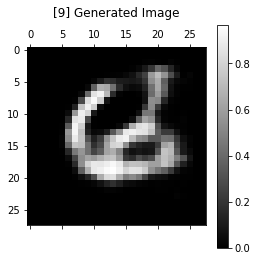

Epoch: [20/50], ELBO: 10004.4150 , Recon: 7477.1538, KLD: 2527.2615


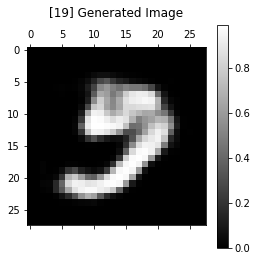

Epoch: [30/50], ELBO: 9998.0225 , Recon: 7463.1938, KLD: 2534.8289


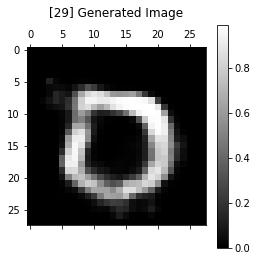

Epoch: [40/50], ELBO: 10070.4375 , Recon: 7619.4214, KLD: 2451.0161


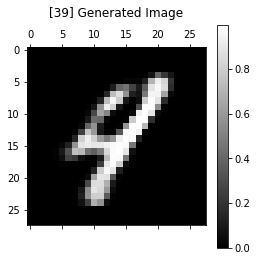

Epoch: [50/50], ELBO: 10252.1631 , Recon: 7709.1670, KLD: 2542.9961


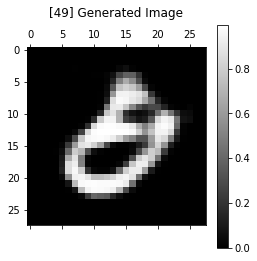

In [15]:
# Training the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28*28))
        #normal = Variable(torch.randn([batch_size,hidden_size])) 
        
        # Forward + Backward + Optimize
        
        recon,mu, log_var = vae(images) # q(z|x)
        recon_loss = F.binary_cross_entropy(recon, images, size_average=False)
        kld_loss = torch.sum(0.5 * (mu**2 + torch.exp(log_var) - log_var -1))
        
        ELBO = recon_loss+kld_loss
        optimizer.zero_grad()
        ELBO.backward()
        optimizer.step()
        
    if (epoch+1) % 10 == 0:
        print ('Epoch: [%d/%d], ELBO: %.4f , Recon: %.4f, KLD: %.4F' 
               % (epoch+1, num_epochs,ELBO.data[0],recon_loss.data[0],kld_loss.data[0]))
        normal = Variable(torch.randn([1,20])) 
        recon = vae.sample(normal)
        plt.matshow(np.reshape(recon.data.numpy(), (28, 28)), cmap=plt.get_cmap('gray'))
        plt.title("[" + str(epoch) + "] Generated Image\n")
        plt.colorbar()
        plt.show()

### test 

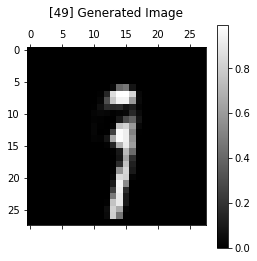

In [12]:
normal = Variable(torch.randn([1,20])) 
recon = vae.sample(normal)

plt.matshow(np.reshape(recon.data.numpy(), (28, 28)), cmap=plt.get_cmap('gray'))
plt.title("[" + str(epoch) + "] Generated Image\n")
plt.colorbar()
plt.show()